In [1]:
from datetime import datetime
import dask.array as da
import os
import time
import h5py
import numpy as np
import xarray as xr
import pandas as pd

import cartopy
import cartopy.feature as cf
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

from matplotlib import patches
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

%run ../functions/functions.ipynb

In [2]:
inputfile = os.path.join('/','home','arturo','github','downpy','data','tmpa_conus_data','data_tmpa_3h_cut.nc')

In [3]:
clat = 33.125
clon = -90.375
npix = 3
dx = 0.25

In [4]:
# f = h5py.File(inputfile, "r")
f = xr.open_dataset(inputfile)
tmpalat = f['lat'][:]
tmpalon = f['lon'][:]
tmplon2d, tmplat2d = np.meshgrid(tmpalon, tmpalat)
nlat = len(tmpalat)
nlon = len(tmpalon)
print(f'nlat: {nlat}')
print(f'nlon: {nlon}')
print()

dates_raw = f['time'].data
dates_raw = pd.to_datetime(dates_raw)
# dates_int = f['dates'][:]
# hours_int = f['hours'][:]

PRE_tmp = f['PRE'].data
print('Original dataset shape = {}'.format(PRE_tmp.shape))
dset = np.swapaxes(PRE_tmp,0,2)
print('Swap dataset shape     = {}'.format(dset.shape)) # too large to fit in memory!

nlat: 12
nlon: 16

Original dataset shape = (2433, 12, 16)
Swap dataset shape     = (16, 12, 2433)


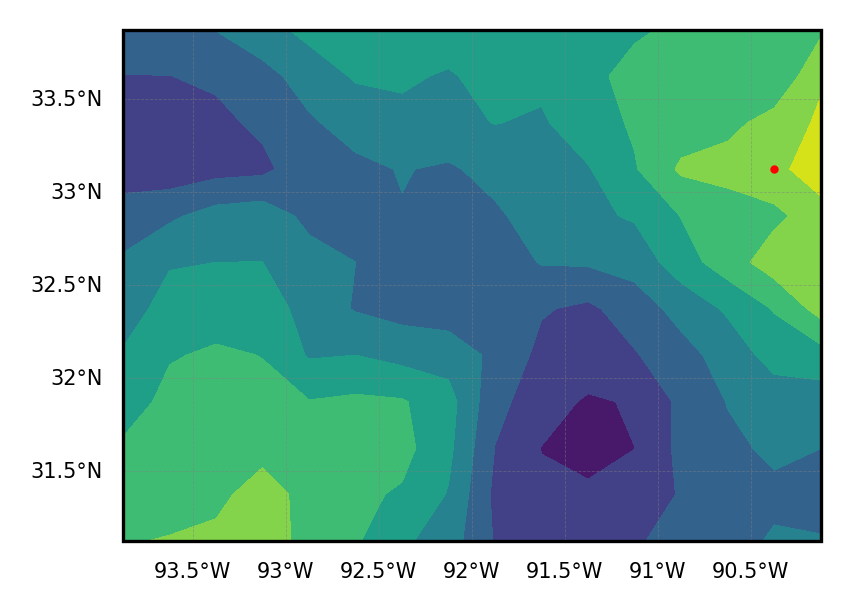

In [5]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(3,3),dpi=300)
gs = gridspec.GridSpec(1,1)

# =============================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
ax1.contourf(tmplon2d, tmplat2d, np.mean(dset, axis=2).T)
ax1.scatter(clon, clat, s=1, c='red')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = True
gl.xlabel_style = {'size': 5, 'color': 'k'}
gl.ylabel_style = {'size': 5, 'color': 'k'}

In [6]:
lat_pos = np.where(tmpalat==clat)[0][0]
lon_pos = np.where(tmpalon==clon)[0][0]
print(lat_pos, lon_pos)
PRE_ref = PRE_tmp[:, lat_pos, lon_pos]

8 14


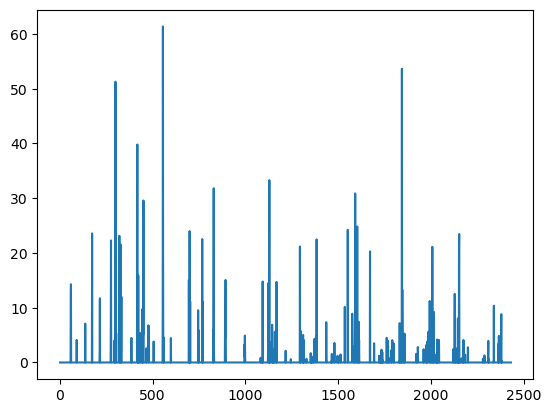

In [7]:
plt.plot(PRE_ref)

In [8]:
# x = da.from_array(dset, chunks=(6, 6, 300))

dates = [datetime.strptime(str(integd).replace('-','')+str(inthour), '%Y%m%d%H')
                    for integd, inthour in zip(dates_raw.date, dates_raw.hour)]

xrs0 = xr.DataArray(dset,  coords={'lon':tmpalon, 'lat':tmpalat, 'time':dates},
                                                    dims=('lon', 'lat', 'time'))
xrs = xrs0.where(xrs0 >= -0.001) # set negative values to np.nan if any

buffer = 0.50*npix*dx
eps = 1e-4
solat = clat - buffer + eps
nolat = clat + buffer + eps
ealon = clon + buffer + eps
welon = clon - buffer + eps
bcond = np.logical_and(
            np.logical_and( xrs.lat > solat, xrs.lat < nolat),
            np.logical_and( xrs.lon > welon, xrs.lon < ealon))
# XARRAY WITH VALUES LOADED IN MEMORY
box_3h = xrs.where(bcond, drop = True).load()
print(box_3h.shape)

(3, 3, 2433)


In [9]:
Tr = 100

thresh=1
L0=0.0001
acf='mar'
dt=3
plot=True
save_yearly = True
tscale=24
toll=0.005
maxmiss=70
opt_method='genetic'

In [10]:
res = {} # initialize dictionary for storing results

xdaily0 = box_3h.resample(time ='{}h'.format(tscale)).sum(dim='time', skipna=False)
xdaily = xdaily0.dropna(dim='time', how='any')
lons = box_3h.lon.values
lats = box_3h.lat.values
nlon = np.size(lons)
nlat = np.size(lats)
dx = np.abs(lons[1] - lons[0])
if nlon != nlat:
    print('downscale warning: box sizes are not equal')
if nlon % 2 == 0:
    print('downscale warning: at least one box size has even length')
if (bool(clat) and bool(clon) and clat in lats and clon in lons):
    clat = lats[np.argmin(np.abs(clat - lats))]
    clon = lons[np.argmin(np.abs(clon - lons))]
    # otherwise us the one provided by the
else:
    clat = lats[np.argmin(np.abs(np.mean(lats) - lats))]
    clon = lons[np.argmin(np.abs(np.mean(lons) - lons))]
L1 = area_lat_long(clat, clon, dx, dx)[0] # in Km
# get the pixel closer to the center as central pixel:
# get the time series for the central pixel
tsc = xdaily.loc[dict(lat = clat, lon = clon)]

In [11]:
# c_excesses = np.maximum(tsc.values-thresh, 0.0)
c_excesses = tsc.values[tsc.values > thresh] - thresh
NCW = wei_fit(c_excesses)
pws = NCW[0]/xdaily.shape[2]
Ns = int(np.floor(pws*365.25))
Cs = NCW[1]
Ws = NCW[2]
print('Number of days: {Ns}')
print(f'Weibull scale: {Cs}')
print(f'Weibull shape: {Ws}')

Number of days: {Ns}
Weibull scale: 11.913970241033375
Weibull shape: 0.775959311606404


In [12]:
# Taylor Hypothesis for downscaling intermittency
print('Downscaling Intermittency')
taylor = downscale_pwet(box_3h, thresh=thresh, dt=dt, L1=L1,
            target_x=L0, target_t=tscale,
            origin_x=L1, origin_t=tscale, ninterp=1000, plot=plot)

print('Downscaling the correlation')
parnames = ['eps', 'alp'] if acf == 'mar' else ['d0', 'mu0']

Downscaling Intermittency
Downscaling the correlation


In [13]:
# Correlation downscaling
print('Computing the correlation')
rcorr = grid_corr(xdaily, plot=plot, thresh=thresh)
gam_s = vrf(L1, L0, (rcorr['{}_s'.format(parnames[0])],
                    rcorr['{}_s'.format(parnames[1])]), acf=acf)

dcorr =  down_corr(rcorr['vdist'], rcorr['vcorr'], L1, acf=acf,
                    use_ave=True, opt_method=opt_method, toll=toll,
                    plot=plot)

Computing the correlation
differential_evolution step 1: f(x)= 0.0013721045584939675
differential_evolution step 2: f(x)= 0.0013721045584939675
differential_evolution step 3: f(x)= 0.0013721045584939675
differential_evolution step 4: f(x)= 0.0013721045584939675
differential_evolution step 5: f(x)= 0.0010291219387385596
differential_evolution step 6: f(x)= 0.0010291219387385596
differential_evolution step 7: f(x)= 0.0010291219387385596
Polishing solution with 'L-BFGS-B'
integration domain is zero


In [14]:
# downscaling the Weibull pdf
print('Downscaling pdf - global Weibull parameters')
par_acf = (dcorr['{}_d'.format(parnames[0])], dcorr['{}_d'.format(parnames[1])])
Nd, Cd, Wd, gam_d, fval_w = down_wei(Ns, Cs, Ws, L1, L0, taylor['beta'], par_acf, acf=acf)

Downscaling pdf - global Weibull parameters
TEST: {'nfev': 28, 'fjac': array([[-1.]]), 'r': array([4.44748496]), 'qtf': array([-6.18789331e-09]), 'fvec': array([3.5971226e-14])}


/tmp/ipykernel_110763/3077059336.py:861: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Wd[ii] = res[0]


In [15]:
print('Downscaling pdf - yearly Weibull parameters')
NCWy, YEARSy = fit_yearly_weibull(tsc, thresh=thresh, maxmiss=maxmiss)
NYd, CYd, WYd, _, _ = down_wei(NCWy[:,0], NCWy[:,1], NCWy[:,2], L1, L0,
                        taylor['beta'], par_acf, acf=acf)

print()
print(f'Global Weibull parameters     : {NCWy} and {YEARSy}')
print(f'Global Weibull Down parameters: {NYd}, {CYd} and {WYd}')

res['NYs'] = NCWy[:,0]
res['CYs'] = NCWy[:,1]
res['WYs'] = NCWy[:,2]
res['NYd'] = NYd
res['CYd'] = CYd
res['WYd'] = WYd

Downscaling pdf - yearly Weibull parameters
TEST: {'nfev': 28, 'fjac': array([[-1.]]), 'r': array([4.47394228]), 'qtf': array([-5.82534732e-09]), 'fvec': array([3.15303339e-14])}

Global Weibull parameters     : [[101.          11.91397024   0.77595931]] and [2018.]
Global Weibull Down parameters: [88.], [13.83065747] and [0.79081405]


/tmp/ipykernel_110763/3077059336.py:861: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Wd[ii] = res[0]


In [16]:
Fi = 1-1/Tr
res['Tr'] = Tr
# x0 = 150.0
x0 = 9.0*np.mean(CYd)

res['mev_d'] = mev_quant(Fi, x0, NYd, CYd, WYd, thresh=thresh)[0]
res['mev_s'] = mev_quant(Fi, x0, NCWy[:,0], NCWy[:,1], NCWy[:,2],
                                            thresh=thresh)[0]

res['gam_d'] = gam_d
res['gam_s'] = gam_s
res['beta'] = taylor['beta']

res['Nd'] = Nd
res['Cd'] = Cd
res['Wd'] = Wd

res['Ns'] = Ns
res['Cs'] = Cs
res['Ws'] = Ws

res['{}_s'.format(parnames[0])] = rcorr['{}_s'.format(parnames[0])]
res['{}_s'.format(parnames[1])] = rcorr['{}_s'.format(parnames[1])]
res['{}_d'.format(parnames[0])] = dcorr['{}_d'.format(parnames[0])]
res['{}_d'.format(parnames[1])] = dcorr['{}_d'.format(parnames[1])]
res['corr_down_success'] =        dcorr['success']
res['corr_down_funval'] =         dcorr['funval']
res['w_down_funval'] = fval_w
res['thresh'] = thresh
res['clat'] = clat
res['clon'] = clon
if plot:
    res['corr_plot'] = dcorr['fig']

/tmp/ipykernel_110763/3077059336.py:1274: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  quant[ii] = res[0]


In [17]:
res

{'NYs': array([101.]),
 'CYs': array([11.91397024]),
 'WYs': array([0.77595931]),
 'NYd': array([88.]),
 'CYd': array([13.83065747]),
 'WYd': array([0.79081405]),
 'Tr': 100,
 'mev_d': 226.0156375861947,
 'mev_s': 209.47186639835255,
 'gam_d': 0.886142524141512,
 'gam_s': 0.9175854003761972,
 'beta': 1.1444905300636994,
 'Nd': 105.0,
 'Cd': 13.847433819938583,
 'Wd': 0.7921232629235103,
 'Ns': 120,
 'Cs': 11.913970241033375,
 'Ws': 0.775959311606404,
 'eps_s': 151.30287941866436,
 'alp_s': 0.9900889088869563,
 'eps_d': 46.179625981670085,
 'alp_d': 0.42642078244116555,
 'corr_down_success': True,
 'corr_down_funval': 0.0010225726966100782,
 'w_down_funval': 3.597122599785507e-14,
 'thresh': 1,
 'clat': 33.125,
 'clon': -90.375,
 'corr_plot': <Figure size 640x480 with 1 Axes>}

In [58]:
from scipy.stats import weibull_min

xx = np.arange(PRE_tmp.shape[0])

# Using Python library Global Weibull
new_rainfall_series2 = weibull_min.rvs(Wd, loc=0, scale=Cd, size=len(xx))

# Rescale new rainfall using max
new_rainfall_rescaled = new_rainfall_series2 * (np.nanmax(PRE_ref) / np.nanmax(new_rainfall_series2))

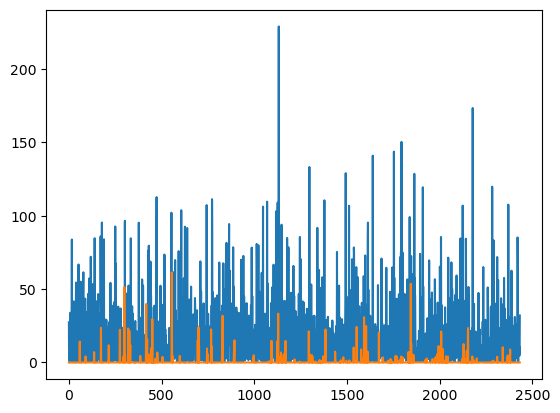

In [61]:
plt.plot(xx, new_rainfall_series2)
plt.plot(xx, PRE_ref)

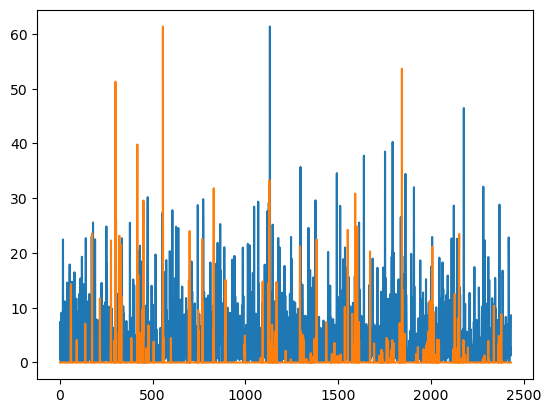

In [63]:
plt.plot(xx, new_rainfall_rescaled)
plt.plot(xx, PRE_ref)

In [20]:
PRE_daily = f.resample(time ='{}h'.format(tscale)).sum(dim='time', skipna=False)
xx = np.arange(PRE_daily['PRE'].shape[0])

In [32]:
Fi

array([0.        , 0.5       , 0.66666667, ..., 0.99974709, 0.99974716,
       0.99974722])

In [37]:
Tr = np.arange(1,len(xx))
Fi = 1 -1/Tr

test = mev_quant(Fi, 0, Nd, Cd, Wd, thresh=1)

/tmp/ipykernel_110763/3077059336.py:1274: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  quant[ii] = res[0]


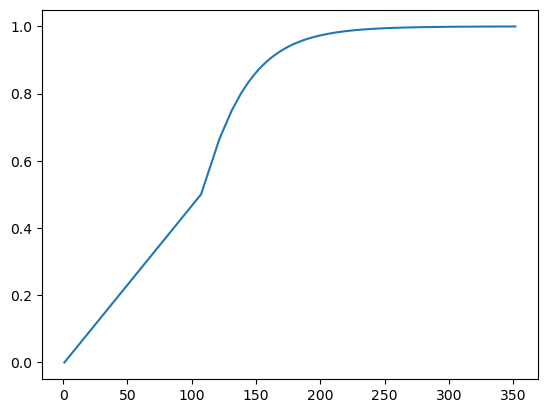

In [38]:
plt.plot(test[0], Fi)

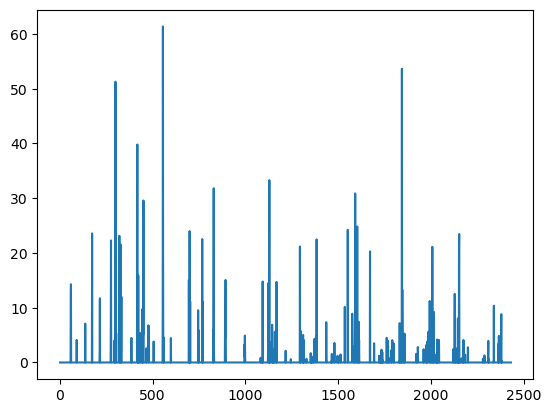

In [62]:
plt.plot(xx, PRE_tmp[:, lat_pos, lon_pos])

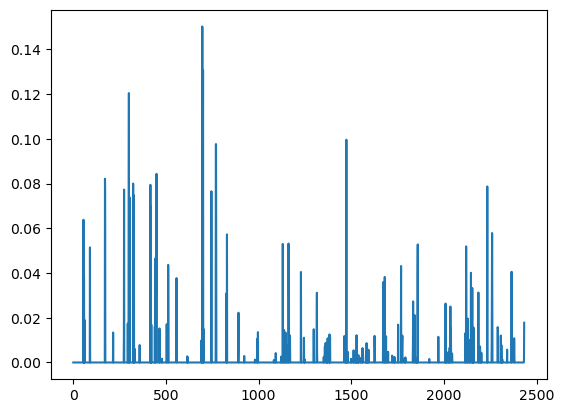

In [ ]:
plt.plot(xx, PRE_tmp[:, lat_pos, lon_pos]/test[0])